<a href="https://colab.research.google.com/github/effepivi/gvxr-tutorials/blob/main/Noise-CBCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 8

## Demo to showcase the result of the integration between ![gVXR](https://github.com/effepivi/gvxr-tutorials/blob/main/img/gvxr_logo.png?raw=1) and ![CIL](https://ccpi.ac.uk/wp-content/uploads/2022/11/CIL-logo-RGB.svg) that we developed during the *CIL Training and Bring Your Own Data User Hackathon* at Cambridge University.
## Author: Franck Vidal

(version 1.0, 23 Mar 2023)

# Aims of this session

1. Simulate a CBCT scan acquisition using gVXR;
2. Add Poisson noise corresponding to a given number of photons per pixel; and
3. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/).


In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic. The voltage is 85 kV. The filtration is 0.1 mm of copper and 1 mm of aluminium. The energy response of the detector is considered. It mimics a 600-micron thick CsI scintillator. 15,000 photons per pixels are used.

![Main parameters of the simulation](https://github.com/effepivi/gvxr-tutorials/blob/main/Noise-CBCT/pediatric-setup.png?raw=12)



# Main steps

1. Download the phantom data. Anthropomorphic data is used. It corresponds to a 5-year old boy. 

2. Extract surface meshes from the voxelied phantom.

3. Simulate an X-ray projection of a Welsh dragon made of quartz

![Simulation of an X-ray projection of a Welsh dragon made of quartz](https://github.com/effepivi/gvxr-tutorials/blob/main/Noise-CBCT/visualisation.png?raw=1)

4. Select the number of incident photons per pixel

5. Add the corresponding amount of Photonic noise 

![X-ray projection with Poisson noise](https://github.com/effepivi/gvxr-tutorials/blob/main/Noise-CBCT/noisy-projection.png?raw=1)

6. Simulate a CT scan

![Scanning eometry](https://github.com/effepivi/gvxr-tutorials/blob/main/Noise-CBCT/CT-geometry.png?raw=12)

7. Create the flat-field images with the corresponding amount of Photonic noise

![Average flat-field image with Poisson noise](https://github.com/effepivi/gvxr-tutorials/blob/main/Noise-CBCT/average-flat-field.png?raw=1)

8. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/)

![Visualisation of the reconstructed 3D volume](https://github.com/effepivi/gvxr-tutorials/blob/main/Noise-CBCT/plotCT.png?raw=1)

In [2]:
from notebook import notebookapp
servers = list(notebookapp.list_running_servers())

if len(servers) > 0:
    !pip install -q condacolab
    import condacolab
    condacolab.install()

✨🍰✨ Everything looks OK!


# Install gVXR, k3D, imagecodecs xpecgen, spekpy and SimpleITK

Run the cell below

```python
!pip3 install gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK itk-rtk
```

In [3]:
from notebook import notebookapp
servers = list(notebookapp.list_running_servers())

if len(servers) > 0:
    !pip3 install -q gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK itk-rtk vtk

  Preparing metadata (setup.py) ... done


In [4]:
from notebook import notebookapp
servers = list(notebookapp.list_running_servers())

if len(servers) > 0:
    !mamba install -c conda-forge -c intel -c astra-toolbox -c ccpi cil numpy astra-toolbox --quiet

In [5]:
%matplotlib inline

Retrieve the path of the notebook. On Macos it may change

In [6]:
import pathlib
root_path = str(pathlib.Path().resolve())

# Copy files

This step is needed when the notebook is executed using Goggle Collaborative

In [7]:
# For Google Collab
import os
import urllib.request

def createDirectory(directory):
    # The directory does not exist
    if not os.path.exists(os.path.abspath(directory)):
    
        # Create the directory
        os.mkdir(os.path.abspath(directory))

def downloadFile(fname):
    if not os.path.exists(fname):
        base_url = "https://github.com/effepivi/gvxr-tutorials/raw/main"
        url = base_url + "/" + fname
        print("Download the polygon mesh (%s)" % fname)
        urllib.request.urlretrieve(url, fname)

createDirectory(root_path + "/JSON")
createDirectory(root_path + "/Noise-CBCT")
createDirectory(root_path + "/Noise-CBCT/meshes")

downloadFile("sitk2vtk.py")
downloadFile("JSON2gVXRDataReader.py")
downloadFile("JSON/Noise-CBCT.json")
downloadFile("energyResponseDetector.txt")
downloadFile("Noise-CBCT/spectrum85kV.txt")
downloadFile("Noise-CBCT/labels.dat")
downloadFile("Noise-CBCT/visualisation.png")
downloadFile("Noise-CBCT/CT-geometry.png")

Download the polygon mesh (Noise-CBCT/visualisation.png)


In [8]:
import glob
import zipfile

import pandas as pd

from IPython.display import display
from IPython.display import Image

import matplotlib.pyplot as plt # Plotting
import numpy as np

from tifffile import imread, imwrite

from IPython.display import display
from IPython.display import Image

import SimpleITK as sitk

import matplotlib # To plot images

font = {'family' : 'serif',
         'size'   : 10
       }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)

has_rtk = True
try:
    import itk
    from itk import RTK as rtk
    print("RTK detected")
except:
    has_rtk = False
    print("RTK not detected")

has_cil = True
try:
    from cil.processors import TransmissionAbsorptionConverter
    from cil.utilities.display import show_geometry, show2D

    # FBP with Tigre or Astra
    from cil.recon import FBP as FBP_recons_cil

    # FDK with Tigre only
    from cil.recon import FDK as FDK_recons_cil # Tigre only
    
    # Do not use
    # from cil.plugins.astra.processors.FDK_Flexible import FDK_Flexible
    
    # FBP and FDK with Astra
    from cil.plugins.astra import FBP as FBP_plugin_astra

    print("CIL detected")
except:
    has_cil = False
    print("CIL not detected")

has_cil_islider = True
try:
    from cil.utilities.jupyter import islicer
except:
    has_cil_islider = False

has_tigre = True
try:
    # FBP and FDK with Tigre
    from cil.plugins.tigre import FBP as FBP_plugin_tigre
    print("Tigre detected")
except:
    has_tigre = False
    print("Tigre not detected")

from ipywidgets import interact
import ipywidgets as widgets

import base64

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr
from gvxrPython3.utils import visualise
from gvxrPython3.utils import plotScreenshot
from gvxrPython3.utils import interactPlotPowerLaw # Plot the X-ray image using a Power law look-up table
from gvxrPython3.utils import saveProjections # Plot the X-ray image in linear, log and power law scales

from sitk2vtk import *

if has_cil:
    from JSON2gVXRDataReader import *

RTK detected
CIL detected
Tigre not detected
SimpleGVXR 2.0.5 (2023-03-09T10:57:28) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.5 (2023-03-09T10:57:28) [Compiler: GNU g++] on Linux


## Initialise GVXR using our JSON file

In [9]:
json_fname = root_path + "/JSON/Noise-CBCT.json"
json2gvxr.initGVXR(root_path + "/JSON/Noise-CBCT.json", renderer="EGL")

Create an OpenGL context: 800x450


## Create the output directory

In [10]:
raw_projection_output_dir = os.path.abspath(json2gvxr.getFilePath(json2gvxr.params["Scan"]["OutFolder"]))
print("The raw projections were saved in", raw_projection_output_dir)
createDirectory(raw_projection_output_dir + "/..")
createDirectory(raw_projection_output_dir)

The raw projections were saved in /content/Noise-CBCT/raw_projections


## Load our detector

In [11]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, -150.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [1152, 1152]
	Detector number of pixels: [1152, 1152]
	Energy response: ../energyResponseDetector.txt in MeV
	Pixel spacing: [0.4340277777777778, 0.4340277777777778, 'mm']


In [12]:
number_of_rows = json2gvxr.params["Detector"]["NumberOfPixels"][1]
number_of_cols = json2gvxr.params["Detector"]["NumberOfPixels"][0]

## Load our source properties

In [13]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, 1000.0, 0.0, 'mm']
	Source shape: PointSource


In [14]:
spectrum, unit_of_energy, energy_set, bin_sets = json2gvxr.initSpectrum(verbose=0)

Text(0.5, 1.0, 'Corresponding spectra')

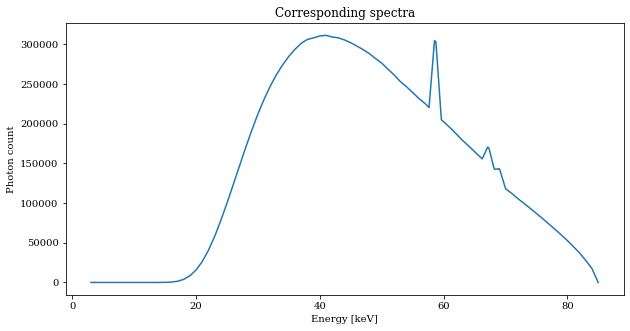

In [15]:
plt.figure(figsize=(10,5))
plt.plot(energy_set, bin_sets)
plt.xlabel("Energy [" + unit_of_energy + "]")
plt.ylabel("Photon count")
plt.title("Corresponding spectra")

## Create the surface meshes

Download and extract the ZIP file.

In [16]:
if not os.path.exists("Noise-CBCT/Pediatric phantom.zip"):
    urllib.request.urlretrieve("https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1",
                               root_path + "/Noise-CBCT/Pediatric phantom.zip")

    with zipfile.ZipFile(root_path + "/Noise-CBCT/Pediatric phantom.zip","r") as zip_ref:
        zip_ref.extractall(root_path + "/Noise-CBCT")

Load the phantom

In [17]:
phantom = sitk.ReadImage(root_path + "/Noise-CBCT/Pediatric phantom/Pediatric_model.mhd")

Load the labels

In [18]:
df = pd.read_csv(root_path + "/Noise-CBCT/labels.dat")

Process every structure of the phantom

In [19]:
meshes = []

for threshold, organ in zip(df["Label"], df["Organs"]):

    # Ignore air
    if organ != "Air":

        print("Process", organ)
        
        mesh_fname = root_path + "/Noise-CBCT/meshes/" + organ + ".stl"
        meshes.append(mesh_fname)

        # Only create the mesh if it does not exist
        if not os.path.exists(mesh_fname):
            
            # Threshold the phantom
            binary_image = (phantom == threshold)

            # Smooth the binary segmentation
            smoothed_binary_image = sitk.AntiAliasBinary(binary_image)
                            
            # Create a VTK image
            vtkimg = sitk2vtk(smoothed_binary_image, centre=True)

            vtk_mesh = extractSurface(vtkimg, 0)
            writeSTL(vtk_mesh, mesh_fname)

Process Muscle
Process Bone
Process Stomach-Interior
Process Cartilage
Process Brain
Process Bladder
Process Gallbladder
Process Heart
Process Kidneys-right
Process Kidneys-left
Process Small-Intestine
Process Large-Intestine
Process Liver
Process Lung-right
Process Lung-left
Process Pancreas
Process Spleen
Process Stomach
Process Thymus
Process Eyes-right
Process Eyes-left
Process Skull
Process Trachea


In [20]:
del phantom

## Load our samples

In [21]:
json2gvxr.initSamples(root_path + "/JSON/Noise-CBCT.json", verbose=1)

Load the 3D data

	Load Muscle in /content/JSON/../Noise-CBCT/meshes/Muscle.stl using mm
	Load Bone in /content/JSON/../Noise-CBCT/meshes/Bone.stl using mm
	Load Stomach-Interior in /content/JSON/../Noise-CBCT/meshes/Stomach-Interior.stl using mm
	Load Cartilage in /content/JSON/../Noise-CBCT/meshes/Cartilage.stl using mm
	Load Brain in /content/JSON/../Noise-CBCT/meshes/Brain.stl using mm
	Load Bladder in /content/JSON/../Noise-CBCT/meshes/Bladder.stl using mm
	Load Gallbladder in /content/JSON/../Noise-CBCT/meshes/Gallbladder.stl using mm
	Load Heart in /content/JSON/../Noise-CBCT/meshes/Heart.stl using mm
	Load Kidneys-right in /content/JSON/../Noise-CBCT/meshes/Kidneys-right.stl using mm
	Load Kidneys-left in /content/JSON/../Noise-CBCT/meshes/Kidneys-left.stl using mm
	Load Small-Intestine in /content/JSON/../Noise-CBCT/meshes/Small-Intestine.stl using mm
	Load Large-Intestine in /content/JSON/../Noise-CBCT/meshes/Large-Intestine.stl using mm
	Load Liver in /content/JSON/../Noise-

In [22]:
gvxr.moveToCentre()

ID = "root"
min_x, min_y, min_z, max_x, max_y, max_z = gvxr.getNodeAndChildrenBoundingBox(ID, "mm")
centre_x = (min_x + max_x) / 2.0
centre_y = (min_y + max_y) / 2.0
centre_z = (min_z + max_z) / 2.0

print("Bounding box:", [min_x, min_y, min_z], [max_x, max_y, max_z])
print("Bounding box centre:", [centre_x, centre_y, centre_z])

Bounding box: [-172.85147094726562, -174.18807983398438, -300.0243225097656] [172.85147094726562, 174.18809509277344, 300.0243225097656]
Bounding box centre: [0.0, 7.62939453125e-06, 0.0]


## Let's get an x-ray image

We create an X-ray image `projection_in_MeV`. 
By default the image is expressed in MeV. 
We convert it to keV for display as follows: `projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")`.

In [23]:
projection_in_MeV = np.array(gvxr.computeXRayImage(), dtype=np.single)
projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")

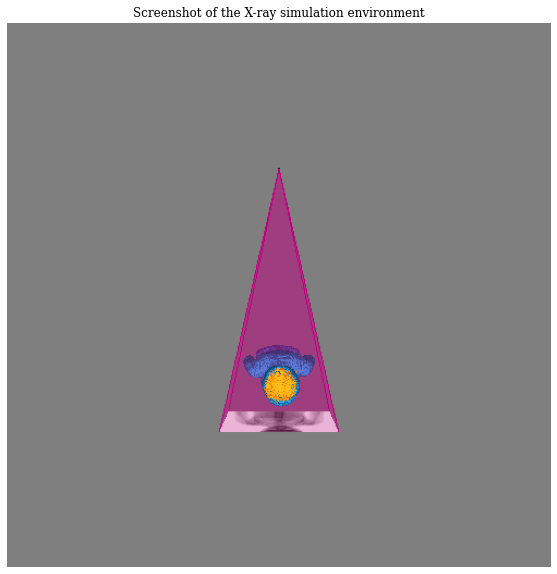

In [24]:
gvxr.setWindowSize(500, 500) # Fix for MacOS
gvxr.displayScene()
plotScreenshot()

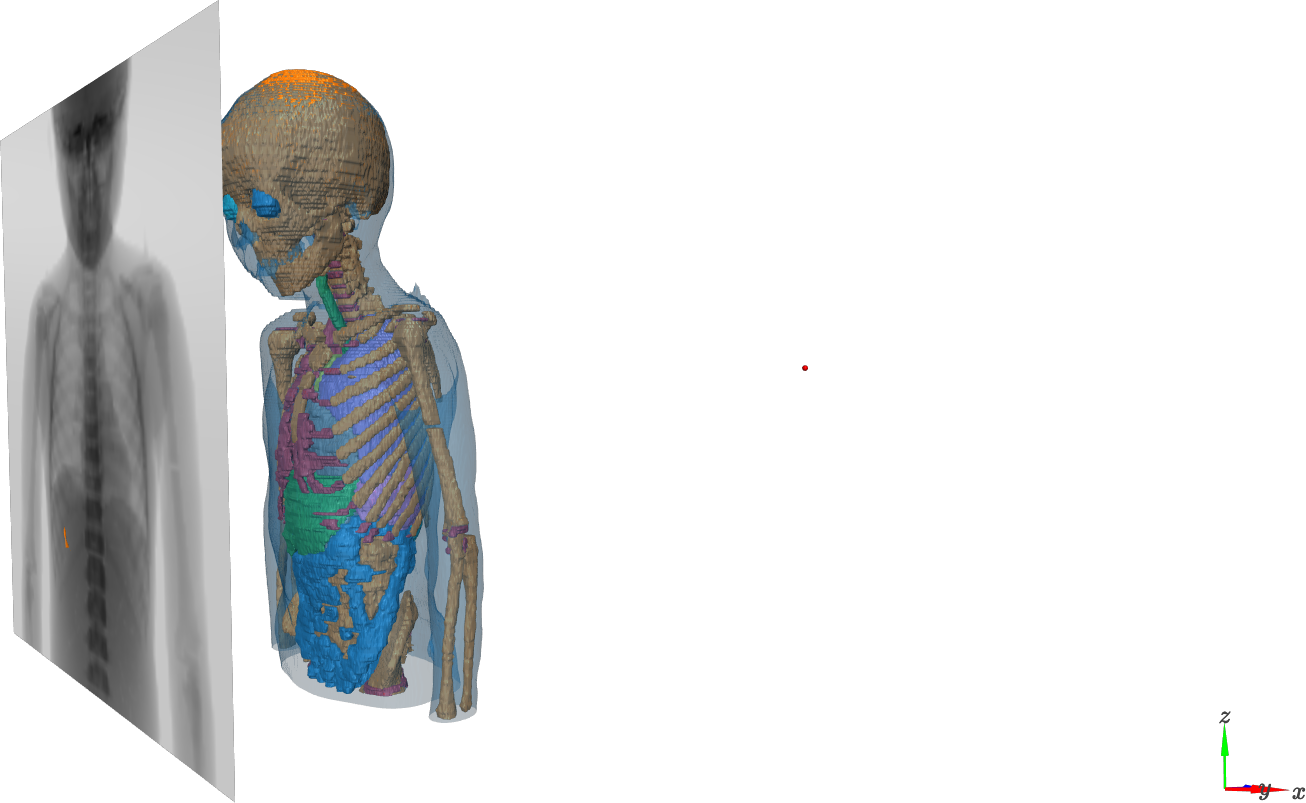

In [25]:
fname = root_path + "/Noise-CBCT/visualisation.png"

if not os.path.exists(fname):

    if len(servers) > 0:
        from google.colab import output
        output.enable_custom_widget_manager()

    plot = visualise(use_log=True)
    plot.grid_visible = False

    if len(servers) > 0:
        from IPython.display import HTML
        plot.snapshot_type = 'inline'
        HTML(plot.get_snapshot())
    else:
        plot.display()
else:
    display(Image(fname, width=800))

In [26]:
if not os.path.exists(fname):
    if plot is not None:
    
        plot.fetch_screenshot()

        data = base64.b64decode(plot.screenshot)
        with open(fname,'wb') as fp:
            fp.write(data)

    if len(servers) > 0:
        from google.colab import output
        output.disable_custom_widget_manager()

## Add Poisson noise

1. Load the raw projection in the RAM
2. Convert the image in keV or MeV into number of photons
3. Add the Poisson noise
4. Convert the image in number of photons into keV or MeV
5. Apply the flat-field correction

In [26]:
def getNoisyImage(x_ray_image_energy, target_number_of_photons_per_pixel):
    
    total_energy_MeV = gvxr.getTotalEnergyWithDetectorResponse()
    number_of_incident_photons_per_pixel = np.sum(gvxr.getPhotonCountEnergyBins())
    energy2photons = number_of_incident_photons_per_pixel / total_energy_MeV

    temp = energy2photons / number_of_incident_photons_per_pixel * target_number_of_photons_per_pixel
    
    # Convert the image in keV into number of photons
    x_ray_image_photons = x_ray_image_energy * temp 
    
    # Add the Poisson noise
    noise_image = np.float32(np.random.poisson(x_ray_image_photons))

    # Convert in energy
    return noise_image / temp

In [27]:
fig_plot = None
def chooseNumberOfPhotonsPerPixel(xray_image: np.array, number_of_photons_per_pixel:int=15000, figsize=(10, 5)):

    """
    Use Matplotlib and a Jupyter widget to display the X-ray image with Poisson noise.
    The number of photons per pixel can be change interactively.

    @param xray_image: The image to display
    @number_of_photons_per_pixel: the number of photons per pixel (default: 15000)
    @gamma figsize: the size of the figure (default: (10, 5))
    """

    global target_number_of_photons_per_pixel, fig_plot
    target_number_of_photons_per_pixel = number_of_photons_per_pixel

    noisy_image = getNoisyImage(xray_image, number_of_photons_per_pixel)

    fig_plot = plt.figure(figsize=figsize)
    ax_img = plt.subplot(111)
    img = plt.imshow(noisy_image, cmap="gray")
    # cbar = fig_plot.colorbar(img, orientation='vertical')
    title_str = "Photons per pixels: " + str(number_of_photons_per_pixel)
    ax_img.set_title(title_str)
    plt.tight_layout()
    plt.margins(0,0)

    plt.close()

    ## Callback function: plot y=Acos(x+phi)
    def update_plot(number_of_photons_per_pixel):
        global target_number_of_photons_per_pixel
        target_number_of_photons_per_pixel = number_of_photons_per_pixel
        noisy_image = getNoisyImage(xray_image, number_of_photons_per_pixel)
        img = ax_img.imshow(noisy_image, cmap="gray")
        title_str = "Photons per pixels: " + str(number_of_photons_per_pixel)
        ax_img.set_title(title_str)
        # fig_plot.colorbar(img, cax=cbar.ax, orientation='vertical')

        display(fig_plot)

    interact(update_plot,
             number_of_photons_per_pixel=widgets.IntSlider(value=number_of_photons_per_pixel, min=10, max=50000, step=10, description="Photons/pixels"))

In [28]:
chooseNumberOfPhotonsPerPixel(projection_in_MeV, number_of_photons_per_pixel=15000, figsize=(10, 5))

interactive(children=(IntSlider(value=15000, description='Photons/pixels', max=50000, min=10, step=10), Output…

In [29]:
fig_plot.savefig(root_path + "/Noise-CBCT/noisy-projection.png", dpi=72)

In [30]:
print("Photons per pixels:", target_number_of_photons_per_pixel)

Photons per pixels: 15000


## Perfom the CT scan

In [31]:
angles = json2gvxr.initScan()

Set up the CT Scan


In [32]:
number_of_angles = json2gvxr.params["Scan"]["NumberOfProjections"]
angles = json2gvxr.doCTScan()

In [33]:
print("First angle:", angles[0])
print("Last angle:", angles[-1])
print("Number of angles:", number_of_angles)

First angle: 0.0
Last angle: 359.4
Number of angles: 600


## Flat images

Create the flat field image

In [34]:
white_slider = widgets.IntSlider(value=25, min=1, max=500, step=1, description='Number of flat images:')
white_slider

IntSlider(value=25, description='Number of flat images:', max=500, min=1)

In [35]:
print("Number of flat images:", white_slider.value)

Number of flat images: 25


In [36]:
createDirectory(root_path + "/Noise-CBCT/flat-field")
fname = root_path + "/Noise-CBCT/flat-field/flat.tif"

total_energy_MeV = gvxr.getTotalEnergyWithDetectorResponse()

temp = total_energy_MeV * np.ones([1, number_of_rows, number_of_cols], dtype=np.single)
flats = []

for i in range(white_slider.value):
    flats.append(getNoisyImage(temp, target_number_of_photons_per_pixel))

flat_field = np.average(flats, axis=0)

imwrite(fname, flat_field.astype(np.single), compression='zlib')

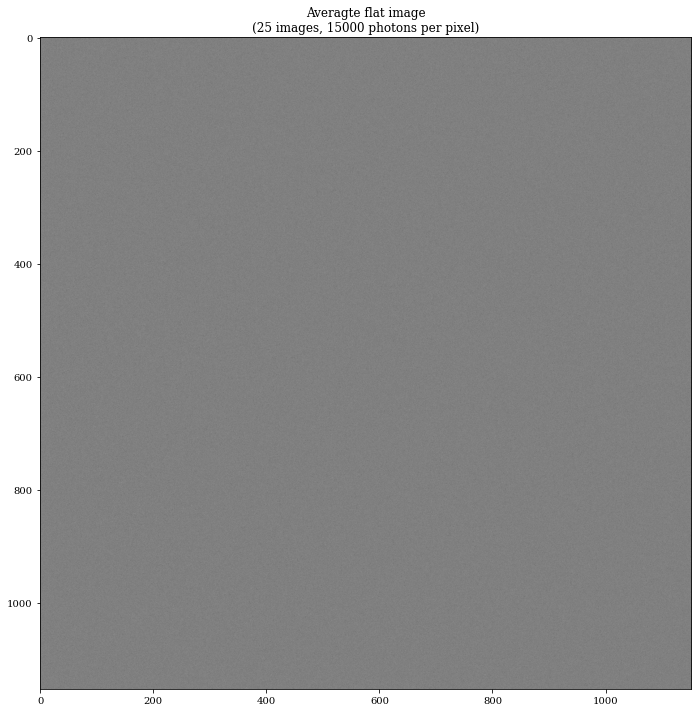

In [37]:
fig = plt.figure(figsize = (20, 10))
plt.title("Averagte flat image\n(" + str(white_slider.value) + " images, " + str(target_number_of_photons_per_pixel) + " photons per pixel)")
img = plt.imshow(flat_field[0], cmap='gray', vmin=total_energy_MeV-0.05*total_energy_MeV, vmax=total_energy_MeV+0.05*total_energy_MeV)
plt.tight_layout()
plt.savefig(root_path + "/Noise-CBCT/average-flat-field.png", dpi=72)

## Add the noise to the projections

In [38]:
createDirectory(root_path + "/Noise-CBCT/noiseless_projections")

raw_projections = []
for i in range(number_of_angles):

    print("Projection", i + 1, "/", number_of_angles, end='\r')

    input_fname = raw_projection_output_dir + "/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    output_fname = root_path + "/Noise-CBCT/noiseless_projections/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    
    # Load the raw projection in the RAM
    x_ray_image_energy = imread(input_fname).astype(np.single)

    # Save it
    imwrite(output_fname, x_ray_image_energy)

    # Add the Poisson noise
    noise_image = getNoisyImage(x_ray_image_energy, target_number_of_photons_per_pixel)

    # Flat-field
    x_ray_image_energy = noise_image / flat_field[0]
    raw_projections.append(x_ray_image_energy.astype(np.single))

    # Overwrite the image
    imwrite(input_fname, raw_projections[-1])

## CT reconstruction

In [39]:
def reconstructFBPWithCIL(data, ig, use_plugins, verbose):
    if verbose > 0: print("Parallel beam detected")

    
    if has_tigre:
        if verbose > 0: print("Backend: Tigre")
        if verbose > 0: print("Use plugin directly: ", use_plugins)

        if use_plugins:
            reconstruction:ImageData | None = FBP_plugin_tigre(ig,data.geometry)(data)
        else:
            reconstruction:ImageData | None = FBP_recons_cil(data, ig, backend="tigre").run()
            
    else:
        if verbose > 0: print("Backend: Astra-Toolbox")
        if verbose > 0: print("Use plugin directly: ", use_plugins)
        
        if use_plugins:
            reconstruction:ImageData | None = FBP_plugin_astra(ig,data.geometry)(data)
        else:
            reconstruction:ImageData | None = FBP_recons_cil(data, ig, backend="astra").run()

    return reconstruction

In [40]:
def reconstructFDKWithCIL(data, ig, use_plugins, verbose):
    if verbose > 0: print("Cone beam detected")

    # if has_tigre:
    #     if verbose > 0: print("Backend: Tigre")
    #     reconstruction:ImageData | None = FDK(data, ig).run()
    # else:
    #     if verbose > 0: print("Backend: Astra-Toolbox")
    #     fbk = FDK_Flexible(ig, data.geometry)
    #     fbk.set_input(data)
    #     reconstruction:ImageData | None = fbk.get_output()

    if has_tigre:
        if verbose > 0: print("Backend: Tigre")
        if verbose > 0: print("Use plugin directly: ", use_plugins)

        if use_plugins:
            reconstruction:ImageData | None = FBP_plugin_tigre(ig,data.geometry)(data)
        else:
            reconstruction:ImageData | None = FDK_recons_cil(data, ig).run()
    else:
        if verbose > 0: print("Backend: Astra-Toolbox")
        if verbose > 0: print("Use plugin directly: ", use_plugins)

        if use_plugins:
            reconstruction:ImageData | None = FBP_plugin_astra(ig,data.geometry)(data)
        else:
            # reconstruction:ImageData | None = FDK_recons_cil(data, ig).run() # Not implemented for Astra
            reconstruction:ImageData | None = None

    return reconstruction

In [41]:
def reconstruct(JSON_fname, use_plugin=False, verbose=0):
    import json
    
    # Opening JSON file
    f = open(JSON_fname)

    # returns JSON object as 
    # a dictionary
    json_data = json.load(f)    
    
    data = None
    reconstruction = None
    
    source_shape = json_data["Source"]["Shape"]

    if verbose > 0:
        print("Source shape:", source_shape)

    # Use CIL
    if has_cil:
    
        if verbose > 0: print("Use CIL")

        reader = JSON2gVXRDataReader(file_name=JSON_fname)
        data = reader.read()

        print("data.geometry", data.geometry)
        
        if has_tigre:
            data.reorder(order='tigre')
            # data.geometry.set_angles(-data.geometry.angles)
        else:
            data.reorder("astra")
            # data.geometry.set_angles(-data.geometry.angles)

        ig = data.geometry.get_ImageGeometry()

        data_corr = TransmissionAbsorptionConverter(white_level=data.max(), min_intensity=0.000001)(data)

        if type(source_shape) == str:

            if source_shape.upper() == "PARALLELBEAM" or source_shape.upper() == "PARALLEL":
                reconstruction:ImageData | None = reconstructFBPWithCIL(data_corr, ig, use_plugin, verbose)

            elif source_shape.upper() == "POINTSOURCE" or source_shape.upper() == "POINT" or source_shape.upper() == "CONE" or source_shape.upper() == "CONEBEAM":
                reconstruction:ImageData | None = reconstructFDKWithCIL(data_corr, ig, use_plugin, verbose)

            else:
                raise ValueError("Unknown source shape:" + source_shape)

        elif type(source_shape) == type([]):
            if source_shape[0].upper() == "FOCALSPOT":
                reconstruction:ImageData | None = reconstructFDKWithCIL(data_corr, ig, use_plugin, verbose)

            else:
                raise ValueError("Unknown source shape:" + source_shape)

        else:
            raise ValueError("Unknown source shape:" + source_shape)    

#     # Use ITK-RTK
#     elif has_rtk:
#         if verbose > 0: print("Use RTK")

#         if type(source_shape) == str:

#             if source_shape.upper() == "PARALLELBEAM" or source_shape.upper() == "PARALLEL":
#                 reconstruction = reconstructFBPWithRTK(verbose)
                
#             elif source_shape.upper() == "POINTSOURCE" or source_shape.upper() == "POINT" or source_shape.upper() == "CONE" or source_shape.upper() == "CONEBEAM":
#                 reconstruction = reconstructFDKWithRTK(verbose)
                
#             else:
#                 raise ValueError("Unknown source shape:" + source_shape)

#         elif type(source_shape) == type([]):
#             if source_shape[0].upper() == "FOCALSPOT":
#                 reconstruction = reconstructFDKWithRTK(verbose)

#             else:
#                 raise ValueError("Unknown source shape:" + source_shape)

#         else:
#             raise ValueError("Unknown source shape:" + source_shape)    

    else:
        raise ValueError("CIL and RTK are not installed")    

    return data, reconstruction

In [ ]:
data, reconstruction = reconstruct(json_fname, True, verbose=1)

Source shape: PointSource
Use CIL
[1152, 1152]
[0.4340277777777778, 0.4340277777777778]
data.geometry 3D Cone-beam tomography
System configuration:
	Source position: [    0., -1000.,     0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [ 0.,  0., -1.]
	Detector position: [  0., 150.,   0.]
	Detector direction x: [-1.,  0.,  0.]
	Detector direction y: [ 0.,  0., -1.]
Panel configuration:
	Number of pixels: [1152 1152]
	Pixel size: [0.43402778 0.43402778]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 600
	Angles 0-20 in degrees:
[ 0.       ,  0.6010017,  1.2020034,  1.803005 ,  2.4040067,  3.0050085,
  3.60601  ,  4.2070117,  4.8080134,  5.409015 ,  6.010017 ,  6.611018 ,
  7.21202  ,  7.8130217,  8.414023 ,  9.015025 ,  9.616027 , 10.217029 ,
 10.81803  , 11.419032 ]
Distances in units: units distance


In [ ]:
if has_cil:
    fig = show_geometry(data.geometry)
    fig.save(root_path  + "/Noise-CBCT/CT-geometry.png", dpi=72)

In [ ]:
if has_cil and has_cil_islider:
    islicer(reconstruction, direction='vertical')

In [ ]:
if has_cil and has_cil_islider:
    islicer(reconstruction, direction='horizontal_x')

In [ ]:
fname = root_path  + "/Noise-CBCT/CT_in_mu.mha"

In [ ]:
reconstruction_as_array = reconstruction.as_array()

In [ ]:
detector_size = np.array(gvxr.getDetectorSize("mm"))
number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels())
spacing = detector_size / number_of_pixels

print("CT volume saved in", fname)
sitk_image = sitk.GetImageFromArray(reconstruction_as_array)
sitk_image.SetSpacing([spacing[0], spacing[0], spacing[1]])
sitk.WriteImage(sitk_image, fname, useCompression=True)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))
plt.suptitle("CT reconstruction with noise")
ax1.imshow(reconstruction_as_array[ reconstruction_as_array.shape[0] // 2, :, :], cmap='gray')
ax2.imshow(reconstruction_as_array[ :, reconstruction_as_array.shape[1] // 2, :], cmap='gray')
ax3.imshow(reconstruction_as_array[ :, :, reconstruction_as_array.shape[2] // 2], cmap='gray')
plt.tight_layout()
plt.savefig(root_path  + "/Noise-CBCT/plotCT.png", dpi=72)

# Cleaning up

Once we have finished it is good practice to clean up the OpenGL contexts and windows with the following command.

In [ ]:
gvxr.terminate()